Importing necessery libraries  

In [1]:
import pyopenms as oms
import pyopenms 
import matplotlib
matplotlib.use('agg')  
import pandas as pd
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import datashade

import datashader.transfer_functions as tf
import colorcet as cc

from datashader.colors import Hot 

read the mzML file using pyopenms

In [2]:

# Create an MSExperiment object to hold the data
exp = pyopenms.MSExperiment()

# Use MzMLFile to load the data
mzml_file = pyopenms.MzMLFile()

# Path to the .mzML file
mzml_file_path = "Fetal_Testis_bRP_Elite_26_f29.mzML"

# Load the data into the experiment object
mzml_file.load(mzml_file_path, exp)

# Get the number of spectra
num_spectra = exp.getNrSpectra()
print(f"Number of spectra: {num_spectra}")


Number of spectra: 17132


Functions for feature extraction

In [67]:


def quntiseIntensityLevels(df,binSize =1):
     # mz_array, intensity_array = spectrum.get_peaks()
     min_mz = df["m/z"].min()
     max_mz = df["m/z"].max()
     print("min m/z", min_mz)
     print("max m/z", max_mz)


     bins = pd.interval_range(start=min_mz, end=max_mz+binSize, freq=binSize, )

     inputDf=pd.DataFrame(
     {
          "bucket_range": bins        
     }
     )
     # Cut the m/z values into bins and assign them to buckets
     df['bucket'] =pd.cut(df["m/z"], bins) 

     intensityArr = []
     for j,bin in enumerate(bins):
          intesityList = df[(df["bucket"] == bin) & (df["intensity"] > 0)]["intensity"].tolist()
          intensityArr.append(sum(intesityList))
     
     
     inputDf["bucket_intensity"]=intensityArr
     
     return inputDf

     

min m/z 300.0001375984002
max m/z 1703.7522244170118


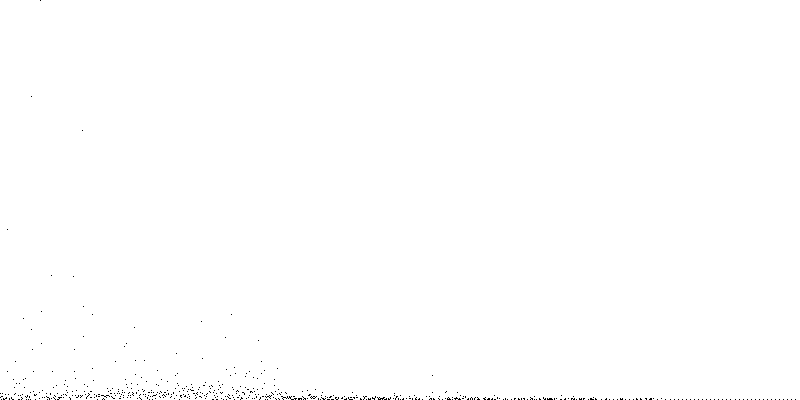

In [86]:

index =0
for spectrum in exp:
    mz_array, intensity_array = spectrum.get_peaks()
    df = pd.DataFrame({
        "m/z": mz_array,
        "intensity": intensity_array
    })
    sampleDf = quntiseIntensityLevels(df,1)
    sampleDf["bucket_avg"] = sampleDf["bucket_range"].apply(lambda x: x.mid)
    canvas = ds.Canvas(plot_width=800, plot_height=400)

    # Aggregate the data
    agg = canvas.points(sampleDf, 'bucket_avg', 'bucket_intensity', agg=ds.count())

    # Create an image from the aggregation
    img = tf.set_background(tf.shade(agg, cmap=Hot),"white")
    # print(sampleDf[sampleDf["bucket_intensity"]>0])
    break

img

<class 'numpy.ndarray'>


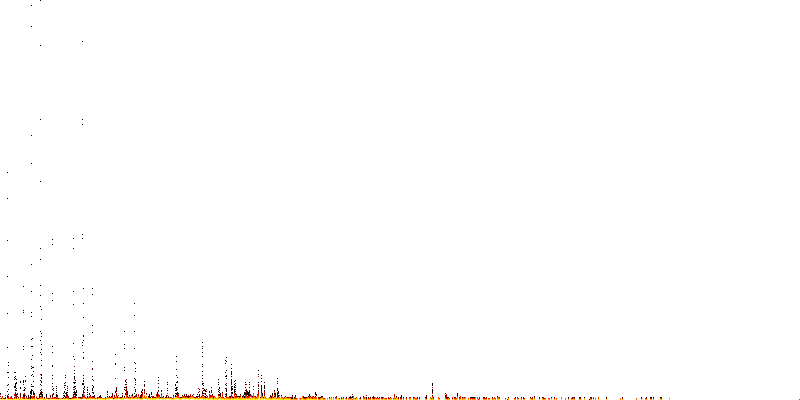

In [88]:

for spectrum in exp:
    mz_array, intensity_array = spectrum.get_peaks()
    print(type(mz_array))
    # print(mz_array[:11])
    # print(type(intensity_array))
    # print(intensity_array[:11])
    df = pd.DataFrame({
        "m/z": mz_array,
        "intensity": intensity_array
    })
    
    canvas = ds.Canvas(plot_width=800, plot_height=400)

    # Aggregate the data
    agg = canvas.points(df, 'm/z', 'intensity', agg=ds.count())

    # Create an image from the aggregation
    img = tf.set_background(tf.shade(agg, cmap=Hot),"white")

    break
img

In [90]:

all_spectra_data = []
count =0


# Iterate through the spectra and print some basic information
for spectrum in exp:
    
    
    print(spectrum)
    print(f"Spectrum has {spectrum.size()} peaks.")
    mz_array = spectrum.get_peaks()[0]  # Mass-to-charge (m/z) values
    intensity_array = spectrum.get_peaks()[1]  # Intensity values
    print(f"First 5 m/z values: {mz_array}")
    print(f"First 5 intensity values: {intensity_array}")
    # if spectrum.getMSLevel() == 1:  # Only MS1 spectra
    
    df = pd.DataFrame({'m/z': mz_array, 'Intensity': intensity_array})
    all_spectra_data.append(hv.Curve(df, kdims=['m/z'], vdims=['Intensity']))
    count +=1
    
    # if (count>10):
    break



# Overlay all spectra
combined_plot = hv.Overlay(all_spectra_data)

# Datashade combined plot
shaded_combined = datashade(combined_plot, aggregator=ds.sum('Intensity'), cmap='inferno')

# Show the plot
# hv.save(shaded_combined, "combined_spectrum.html")

Spectrum has 31313 peaks.
First 5 m/z values: [ 300.0001376   300.0006931   300.00124861 ... 1703.73718806 1703.74470621
 1703.75222442]
First 5 intensity values: [0. 0. 0. ... 0. 0. 0.]


:DynamicMap   []